# Part 1a: Classification with Decision Trees
**DUE September 17th 2018**

## Introduction

The code for this project consists of several Python files, some of
which you will need to read and understand in order to complete the
assignment, and some of which you can ignore.

### Files You'll Edit

``assignment_1b.ipynb``: Will be your edited copy of this notebook pertaining to part 1a of the assignment.

`titanic-features.py`: This contains some functions to help you apply a decision tree to the Titanic dataset.


### Files you might want to look at
  
``binary.py``: Our generic interface for binary classifiers (actually
works for regression and other types of classification, too).

``datasets.py``: Where a handful of test data sets are stored.

``util.py``: A handful of useful utility functions: these will
undoubtedly be helpful to you, so take a look!

``runClassifier.py``: A few wrappers for doing useful things with
classifiers, like training them, generating learning curves, etc.

``mlGraphics.py``: A few useful plotting commands

``data/*``: all of the datasets we'll use.

### What to Submit

You will hand in all of the python files listed above under "Files
you'll edit". You will also have to answer the written questions in this
notebook denoted **Q#:** in the corresponding cells denoted with **A#:**.

#### Autograding

Your code will be autograded for technical correctness. Please **do
not** change the names of any provided functions or classes within the
code, or you will wreak havoc on the autograder. However, the
correctness of your implementation -- not the autograder's output --
will be the final judge of your score.  If necessary, we will review
and grade assignments individually to ensure that you receive due
credit for your work.

In [1]:
# Jupyter magic!
%matplotlib inline

## 0. Warming up to Classifiers (10%)

Let's begin our foray into classification by looking at some very
simple classifiers.  There are three classifiers
in ``dumbClassifiers.py``, one is implemented for you, the other
two you will need to fill in appropriately.

The already implemented one is ``AlwaysPredictOne``, a classifier that
(as its name suggest) always predicts the positive class.  We're going
to use the ``TennisData`` dataset from ``datasets.py`` as a running
example.  So let's start up python and see how well this classifier
does on this data.  You should begin by importing ``util``,
``datasets``, ``binary`` and ``dumbClassifiers``.

In [2]:
import dumbClassifiers, datasets
import numpy as np

In [3]:
h = dumbClassifiers.AlwaysPredictOne({})
h.train(datasets.TennisData.X, datasets.TennisData.Y)
h.predictAll(datasets.TennisData.X)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Indeed, it looks like it's always predicting one!

Now, let's compare these predictions to the truth.  Here's a very
clever way to compute accuracies 


In [4]:
np.mean((datasets.TennisData.Y > 0) == (h.predictAll(datasets.TennisData.X) > 0))

0.6428571428571429

**Q1:** Why is this computation equivalent to computing classification accuracy?

**A1:** In this case it's equivalent because the most frequent Y value is 1.

That's training accuracy; let's check test accuracy:

In [5]:
np.mean((datasets.TennisData.Yte > 0) == (h.predictAll(datasets.TennisData.Xte) > 0))

0.5

Okay, so it does pretty badly.  That's not surprising, it's really not
learning anything!!!

Now, let's use some of the built-in functionality to help do some of
the grunt work for us.  We'll need to import ``runClassifier``.

In [6]:
import runClassifier

In [7]:
runClassifier.trainTestSet(h, datasets.TennisData)

Training accuracy 0.642857, test accuracy 0.5


Very convenient!

Now, your first implementation task will be to implement the missing
functionality in ``AlwaysPredictMostFrequent``.  This actually
will "learn" something simple.  Upon receiving training data, it will
simply remember whether +1 is more common or -1 is more common.  It
will then always predict this label for future data.  **Once you've
implemented this**, you can test it:

In [8]:
h = dumbClassifiers.AlwaysPredictMostFrequent({})
#h.train(datasets.TennisData.X, datasets.TennisData.Y)
#h.predictAll(datasets.TennisData.X)
runClassifier.trainTestSet(h, datasets.TennisData)

Training accuracy 0.642857, test accuracy 0.5


It turns out that its behavior is exactly the same as ``AlwaysPredictOne``
since +1 is most common in the TennisData training set.
If we change to a different dataset: ``SentimentData`` is
the data you've seen before, now Python-ified,
AlwaysPredictMostFrequent will still predict the same as
AlwaysPredictOne since +1 is also the most common in the
SentimentData dataset.

In [9]:
runClassifier.trainTestSet(dumbClassifiers.AlwaysPredictOne({}), datasets.SentimentData)

Training accuracy 0.504167, test accuracy 0.5025


In [10]:
runClassifier.trainTestSet(dumbClassifiers.AlwaysPredictMostFrequent({}), datasets.SentimentData)

Training accuracy 0.504167, test accuracy 0.5025


The last dumb classifier we'll implement
is ``FirstFeatureClassifier``.  This actually does something
slightly non-trivial.  It looks at the first feature
(i.e., ``X[0]``) and uses this to make a prediction.  Based on
the training data, it figures out what is the most common class for
the case when ``X[0] > 0`` and the most common class for the case
when ``X[0] <= 0``.  Upon receiving a test point, it checks the
value of ``X[0]`` and returns the corresponding class.  **Once
you've implemented this**, you can check it's performance:

In [11]:
################################################################################
# TODO: Implement FirstFeatureClassifier                                       #
################################################################################
runClassifier.trainTestSet(dumbClassifiers.FirstFeatureClassifier({}), datasets.TennisData)

Training accuracy 0.714286, test accuracy 0.666667


In [12]:
runClassifier.trainTestSet(dumbClassifiers.FirstFeatureClassifier({}), datasets.SentimentData)

Training accuracy 0.504167, test accuracy 0.5025


## 1. Decision Trees

Our next task is to implement a decision tree classifier.  There is
stub code in ``dt.py`` that you should edit.  Decision trees are
stored as simple data structures.  Each node in the tree has
a ``.isLeaf`` boolean that tells us if this node is a leaf (as
opposed to an internal node).  Leaf nodes have a ``.label`` field
that says what class to return at this leaf.  Internal nodes have:
a ``.feature`` value that tells us what feature to split on;
a ``.left`` *tree* that tells us what to do when the feature
value is *less than 0.5*; and a ``.right`` *tree* that
tells us what to do when the feature value is *at least 0.5*.
To get a sense of how the data structure works, look at
the ``displayTree`` function that prints out a tree.

Your first task is to implement the training procedure for decision
trees.  We've provided a fair amount of the code, which should help
you guard against corner cases.  (Hint: take a look
at ``util.py`` for some useful functions for implementing
training.  **Once you've implemented the training function**, we can test
it on simple data:


In [13]:
import dt

In [14]:
h = dt.DT({'maxDepth': 1})
h

Leaf 1

In [15]:
################################################################################
# TODO: Implement dt.train(...)                                                #
################################################################################
h.train(datasets.TennisData.X, datasets.TennisData.Y)
h

Branch 6
  Leaf 1.0
  Leaf -1.0

This is for a simple depth-one decision tree (aka a decision stump).
If we let it get deeper, we get things like:

In [16]:
h = dt.DT({'maxDepth': 2})
h.train(datasets.TennisData.X, datasets.TennisData.Y)
h

Branch 6
  Branch 7
    Leaf 1.0
    Leaf 1.0
  Branch 1
    Leaf -1.0
    Leaf 1.0

In [20]:
h = dt.DT({'maxDepth': 5})
h.train(datasets.TennisData.X, datasets.TennisData.Y)
h

Branch 6
  Branch 7
    Leaf 1.0
    Branch 2
      Leaf 1.0
      Leaf -1.0
  Branch 1
    Branch 5
      Branch 4
        Leaf -1.0
        Branch 3
          Leaf -1.0
          Leaf 1.0
      Leaf 1.0
    Leaf 1.0

We can do something similar on the sentiment data (this will take a bit longer---it takes about 10 seconds on my laptop):

In [18]:
h = dt.DT({'maxDepth': 2})
h.train(datasets.SentimentData.X, datasets.SentimentData.Y)
h

Branch 626
  Branch 683
    Leaf 1.0
    Leaf -1.0
  Branch 1139
    Leaf -1.0
    Leaf 1.0

In [71]:
h = dt.DT({'maxDepth': 5})
h.train(datasets.SentimentData.X, datasets.SentimentData.Y)
h

Branch 626
  Branch 683
    Branch 1431
      Branch 1437
        Branch 3907
          Leaf 1.0
          Leaf -1.0
        Branch 2321
          Leaf -1.0
          Leaf 1.0
      Branch 5011
        Branch 2122
          Leaf -1.0
          Leaf 1.0
        Leaf 1.0
    Branch 1759
      Branch 3229
        Branch 5199
          Leaf -1.0
          Leaf 1.0
        Leaf 1.0
      Leaf 1.0
  Branch 1139
    Branch 2445
      Branch 4159
        Branch 4536
          Leaf -1.0
          Leaf 1.0
        Branch 990
          Leaf 1.0
          Leaf -1.0
      Branch 398
        Leaf 1.0
        Leaf -1.0
    Branch 1466
      Branch 5180
        Branch 4128
          Leaf 1.0
          Leaf -1.0
        Leaf -1.0
      Branch 4519
        Branch 1327
          Leaf -1.0
          Leaf 1.0
        Leaf 1.0

The problem here is that words have been converted into numeric ids
for features. We can look them up (your results here might be
different due to hashing):

In [64]:
print(2428, datasets.SentimentData.words[2428])
print(3842, datasets.SentimentData.words[3842])
print(3892, datasets.SentimentData.words[3892])

2428 deliver
3842 reportedly
3892 wraps


Based on this, we can rewrite the tree (by hand) as:

```python
Branch 'bad'
  Branch 'worst'
    Leaf -1.0
    Leaf 1.0
  Branch 'sequence'
    Leaf -1.0
    Leaf 1.0
```

Now, you should **go implement prediction**.  This should be easier than
training!  We can test by (this takes about a minute for me):

In [65]:
################################################################################
# TODO: Implement dt.predict(...)                                              #
################################################################################
runClassifier.trainTestSet(dt.DT({'maxDepth': 1}), datasets.SentimentData)
runClassifier.trainTestSet(dt.DT({'maxDepth': 3}), datasets.SentimentData)
runClassifier.trainTestSet(dt.DT({'maxDepth': 5}), datasets.SentimentData)

Training accuracy 0.630833, test accuracy 0.595
Training accuracy 0.701667, test accuracy 0.6175
Training accuracy 0.765833, test accuracy 0.625


Looks like it does better than the dumb classifiers on training data,
as well as on test data!  Hopefully we can do even better in the
future!

We can use more ``runClassifier`` functions to generate learning
curves and hyperparameter curves:

Training classifier on 2 points...
Training accuracy 1, test accuracy 0.5
Training classifier on 3 points...
Training accuracy 1, test accuracy 0.5
Training classifier on 5 points...
Training accuracy 1, test accuracy 0.5
Training classifier on 10 points...
Training accuracy 1, test accuracy 0.595
Training classifier on 19 points...
Training accuracy 1, test accuracy 0.48
Training classifier on 38 points...
Training accuracy 1, test accuracy 0.62
Training classifier on 75 points...
Training accuracy 1, test accuracy 0.56
Training classifier on 150 points...
Training accuracy 0.953333, test accuracy 0.56
Training classifier on 300 points...
Training accuracy 0.926667, test accuracy 0.575
Training classifier on 600 points...
Training accuracy 0.881667, test accuracy 0.5975
Training classifier on 1200 points...
Training accuracy 0.833333, test accuracy 0.6475


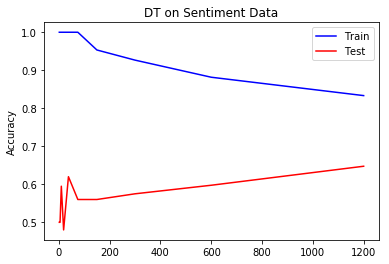

In [66]:
curve = runClassifier.learningCurveSet(dt.DT({'maxDepth': 9}), datasets.SentimentData)
runClassifier.plotCurve('DT on Sentiment Data', curve)

This plots training and test accuracy as a function of the number of
data points (x-axis) used for training and y-axis is accuracy.

**Q2:** We should see training accuracy (roughly) going down and test
accuracy (roughly) going up.  Why does training accuracy tend to go
*down?* 

**A2:** The training accuracy is dropping due to overfitting as the training data is being increased. As the training example increase the training accuracy decreases as it is taking in the noise/corner case and generalizing it.

**Q3:** Why is test accuracy not monotonically increasing? 

**A3:** The test accuracy might be increasing because at the start the training data is too less for training algorithm to learn properly. So in turn the test accuracy is not monotonically increasing.

**Q4:** You should also see jaggedness in the test curve toward the left. Why?

**A4:** Again the jaggedness at the left or start of the curve might be due to less training data and the training algorithm not learning properly and making very random predictions on the test data. (Underfitting)

We can also generate similar curves by changing the maximum depth hyperparameter:

Training classifier with maxDepth=1...
Training accuracy 0.630833, test accuracy 0.595
Training classifier with maxDepth=2...
Training accuracy 0.6675, test accuracy 0.5825
Training classifier with maxDepth=4...
Training accuracy 0.7325, test accuracy 0.6375
Training classifier with maxDepth=6...
Training accuracy 0.789167, test accuracy 0.635
Training classifier with maxDepth=8...
Training accuracy 0.823333, test accuracy 0.6475
Training classifier with maxDepth=12...
Training accuracy 0.863333, test accuracy 0.6425
Training classifier with maxDepth=16...
Training accuracy 0.888333, test accuracy 0.625


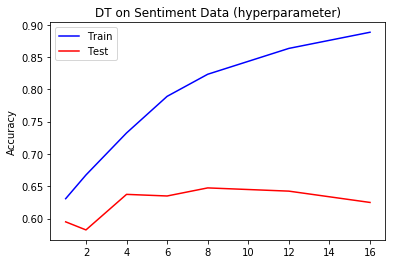

In [67]:
curve = runClassifier.hyperparamCurveSet(dt.DT({}), 'maxDepth', [1,2,4,6,8,12,16], datasets.SentimentData)
runClassifier.plotCurve('DT on Sentiment Data (hyperparameter)', curve)

Now, the x-axis is the value of the maximum depth.

**Q5:** You should see training accuracy monotonically increasing and
test accuracy making something like a hill.  Which of these is
*guaranteed* to happen a which is just something we might expect to
happen?  Why?

**A5:** As the tree size increases, accuracy increases. However, as the tree size increases the test accuracy increases at first since we expect test data to be similar to train data but at some point the training algorithm starts training noise in the data and becomes less accurate on the test data.
The hill curve of test data is expected to happen as at certain point we are no longer trying to fit the data and instead fitting the noize of the data. At this point the testing accuracy decreases as the tree is too big and complex to perform well on testing data(Occams razor). This is called overfitting the data. 
There is tradeoff to be made between test accuracy and tree size.